# Make Sure the ML Model Fitted Correctly

In [1]:
# Create a strategy using the trained model
# Backtest using timerange TRAINVAL, and pairs of trained model
# Make sure the profit graph is upwards (ofc coz we BT'ed in train and val date)

In [1]:
%load_ext autoreload
%autoreload 2
%env WANDB_SILENT=true

from pathlib import Path
from copy import deepcopy
import matplotlib.pyplot as plt
import pandas as pd
import quantstats as qs
import os
import logging
import sys
import nest_asyncio

nest_asyncio.apply()

while "freqtrade" not in os.listdir():
    os.chdir("..")
    if "freqtrade" in os.listdir():
        nest_asyncio.apply()
        logger = logging.getLogger("freqtrade.nbtools")
        handler = logging.StreamHandler(stream=sys.stdout)
        handler.setFormatter(logging.Formatter("%(name)s - %(message)s"))
        logger.addHandler(handler)
        logger.setLevel(logging.DEBUG)

# Freqtrade Imports
from freqtrade.optimize.optimize_reports import text_table_add_metrics
from freqtrade.nbtools.preset import ConfigPreset
from freqtrade.nbtools.backtest import backtest, DataLoader
from freqtrade.nbtools.remote_utils import load_lightning_container
from freqtrade.nbtools.helper import parse_function_body
from freqtrade.nbtools import plotting, configs
from freqtrade.ml import lightning_utils

# Constants
PATH_MOUNT = Path.cwd().parent / "mount"
DATALOADER = DataLoader(max_n_datasets=5)

# Custom function
def string_templating(string: str, data: dict, strip_doublequotes=False):
    _string = deepcopy(string)
    """Replace [|key|] in string with data["key"] """
    for key, value in data.items():
        to_replace = "[|{}|]".format(key)
        if strip_doublequotes:
            to_replace = "\"[|{}|]\"".format(key)
        if to_replace not in string:
            raise Exception(f"Not found formatting with key '{key}'")
        _string = _string.replace(to_replace, str(value))
    return _string


def start_backtesting(strat_func, lightning_name: str, bt_type: str, version="latest"):
    PATH_LOCAL_DATADIR = PATH_MOUNT / "data"
    LIGHTNING_CONTAINER_NAME = lightning_name

    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version=version)
    
    if bt_type == "val":
        timerange = lightning_utils.get_timerange_trainval(lightning_container)
    elif bt_type == "opt":
        timerange = lightning_utils.get_timerange_opt(lightning_container)
    elif bt_type == "test":
        timerange = lightning_utils.get_timerange_test(lightning_container)
    else:
        raise Exception(f"Unknown BT type: {bt_type}")
    
    preset = ConfigPreset(
        name=f"ml_{bt_type}_{LIGHTNING_CONTAINER_NAME}",
        config_dict = configs.DEFAULT,
        path_data=PATH_LOCAL_DATADIR,
        timerange=timerange
    )
    preset.overwrite_config(pairs=lightning_container.config.pairs)

    strategy_code = string_templating(
        parse_function_body(strat_func),
        data={"LIGHTNING_CONTAINER_NAME": LIGHTNING_CONTAINER_NAME}
    )
    stats, summary = backtest(preset, strategy_code, dataloader=DATALOADER)
    return stats, summary, preset

env: WANDB_SILENT=true
freqtrade.nbtools.backtest - Initialized DataLoader with 5 max datas.


# Model Validation

In [16]:
"""
This strategy will backtested in Train and Validation date.
To make sure the model was fitted correctly, you need to know that you model is predicting accurately in this date.
Create the strategy that BUYS when the ML Model predicts the future is going to UP, and do the same for the sell.
The strategy doesn't need to be trend following, but the final backtest results must profitable steadily.

NOTE! Please indent the hashtag when commenting!
NOTE! Please indent the hashtag when commenting!
NOTE! Please indent the hashtag when commenting!
"""

def val_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="latest")        
    
    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {"0": 99}
        stoploss = -0.99
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_classes = 5
            dataframe = lightning_container.predict(dataframe)
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe["argmax_ml"] == "ml_4",
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
                        
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            
            self.print_once(dataframe.info(), "info_df")
            self.print_once(dataframe.describe(), "describe_df")
            self.print_once(dataframe, "populate_buy_sell")
            
            return dataframe
    """ End Strategy Code """

freqtrade.nbtools.remote_utils - Load LightningContainer version 'latest' of project: '15n30-catboost_intentional' - asset_name: '15n30-catboost_intentional'.
freqtrade.nbtools.remote_utils - WARNING: You are using the LATEST version of LightningContainer asset!
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 5 pairs)
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 5 pairs)
freqtrade.nbtools.preset.base_preset - Setting config for 15n30-catboost_intentional ...
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to C:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20160821-20210620
freqtrade.nbtools.remote_utils - Load LightningContainer version 'latest' of project: '15n30-catboost_intentional' - asset_name: '15n30-catboost_intentional'.
freqtrade.nbtools.remote_utils - WARNING: You are using the LATEST version of LightningContainer asset!
freqtrade.nbtools.helpe

Populating Indicators:   0%|          | 0/4 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110845 entries, 500 to 111344
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   date       110845 non-null  datetime64[ns, UTC]
 1   open       110845 non-null  float64            
 2   high       110845 non-null  float64            
 3   low        110845 non-null  float64            
 4   close      110845 non-null  float64            
 5   volume     110845 non-null  float64            
 6   ml_0       110843 non-null  float64            
 7   ml_1       110843 non-null  float64            
 8   ml_2       110843 non-null  float64            
 9   ml_3       110843 non-null  float64            
 10  ml_4       110843 non-null  float64            
 11  argmax_ml  110843 non-null  object             
 12  buy        110845 non-null  int64              
 13  sell       110845 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64

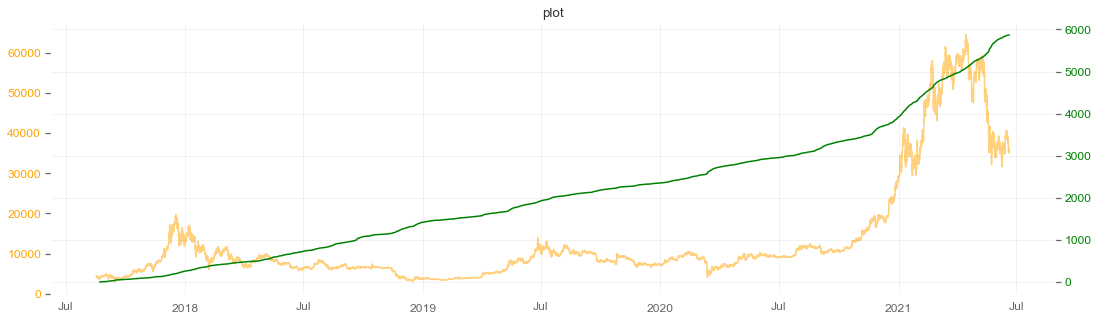

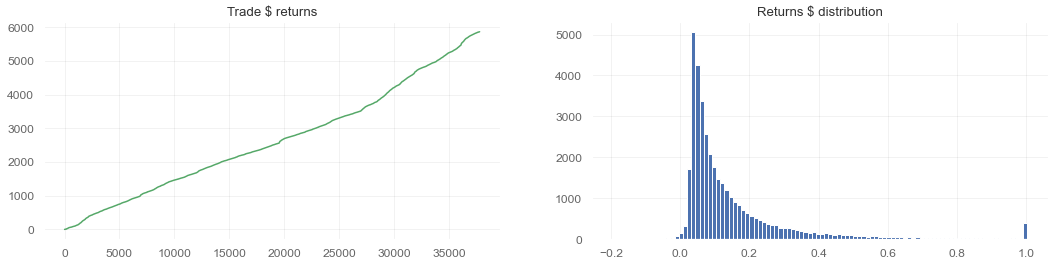

,Portfolio Summary
Trades,37786
Min Balance,0.047825
Max Balance,5871.769343
Final Balance,5871.769343
Avg. Return (%),1.034934
Avg. Return ($),0.155395
Avg. Trade Duration (h),0 days 00:36:16.067855819


freqtrade.nbtools.remote_utils - Adding new row to table...
freqtrade.nbtools.remote_utils - Columns are not identical.
freqtrade.nbtools.remote_utils - New columns    : []
freqtrade.nbtools.remote_utils - Removed columns: ['pairlist', 'daily_profit']
freqtrade.nbtools.remote_utils - Inserting 'None' to removed columns
freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |  '15n30-catboost_intentional__backtest-2021-09-01_19-28-14'
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  
freqtrade.nbtools.backtest - ===============================


In [17]:
MODEL_NAME = "15n30-catboost_intentional"
MODEL_VER = "latest"

stats, summary, preset = start_backtesting(val_strategy, MODEL_NAME, "val", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)

# Model x Strategy Optimization

In [18]:
""" 
In this phase, tinker your strategy until you get the "Sweet Spot"!
"""

def opt_strategy():
    """ Start Strategy Code """
    from freqtrade.nbtools.strategy import INbStrategy
    from freqtrade.nbtools.remote_utils import load_lightning_container
    from freqtrade.ml.container import LightningContainer
    from pandas import DataFrame
    from functools import reduce
    import numpy as np  # noqa
    import pandas as pd  # noqa
    import talib.abstract as ta
    
    LIGHTNING_CONTAINER_NAME = "[|LIGHTNING_CONTAINER_NAME|]"
    lightning_container = load_lightning_container(LIGHTNING_CONTAINER_NAME, LIGHTNING_CONTAINER_NAME, version="latest")        
    
    
    class NotebookStrategy(INbStrategy):
        # These attributes are REQUIRED!
        timeframe = lightning_container.config.timeframe
        minimal_roi = {"0": 99}
        stoploss = -0.99
        startup_candle_count: int = 500
                    
        def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            dataframe["ema"] = ta.EMA(dataframe, timeperiod=200)
            dataframe = lightning_container.predict(dataframe)
            
            num_classes = 5
            dataframe["argmax_ml"] = dataframe[[f"ml_{x}"for x in range(num_classes)]].idxmax(axis=1)
            return dataframe

        def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            conditions = [
                dataframe['close'] > dataframe['ema'],
                dataframe['argmax_ml'] == "ml_4",
                # dataframe['ml_4'] > 0.5,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'buy'] = 1
            return dataframe

        def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
            num_candles_forward = lightning_container.config.num_future_candles
            conditions = [
                dataframe['buy'].shift(num_candles_forward) == 1,
                dataframe['volume'] > 0,
            ]
            
            dataframe.loc[reduce(lambda x, y: x & y, conditions), 'sell'] = 1
            return dataframe
    """ End Strategy Code """

freqtrade.nbtools.remote_utils - Load LightningContainer version 'latest' of project: '15n30-catboost_intentional' - asset_name: '15n30-catboost_intentional'.
freqtrade.nbtools.remote_utils - WARNING: You are using the LATEST version of LightningContainer asset!
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 5 pairs)
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 5 pairs)
freqtrade.nbtools.preset.base_preset - Setting config for 15n30-catboost_intentional ...
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to C:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20210621-20210720
freqtrade.nbtools.remote_utils - Load LightningContainer version 'latest' of project: '15n30-catboost_intentional' - asset_name: '15n30-catboost_intentional'.
freqtrade.nbtools.remote_utils - WARNING: You are using the LATEST version of LightningContainer asset!
freqtrade.nbtools.helpe

Populating Indicators:   0%|          | 0/4 [00:00<?, ?it/s]

freqtrade.nbtools.helper - "Backtest" executed in 1.45s
freqtrade.nbtools.backtest - Logging preset...
freqtrade.nbtools.backtest - [LOG PRESET OFFLINE SUCCESS]
freqtrade.nbtools.backtest - Sync preset with name: 15n30-catboost_intentional__backtest-2021-09-01_19-34-19
freqtrade.nbtools.backtest - with random name: destroyed-batman-charger
freqtrade.nbtools.backtest - [WANDB LOG PRESET CONTINUES IN BACKGROUND]
freqtrade.nbtools.helper - "Whole Backtesting Process (Backtest + Log)" executed in 27.55s


C:\CS\Python\crypto-collection\freqtrade\superft\freqtrade\nbtools\backtest.py:392: RuntimeWarning: divide by zero encountered in double_scalars
  "profit_per_drawdown": trades_summary["profit_total_abs"] / abs(trades_summary["max_drawdown_abs"]),
C:\CS\Python\crypto-collection\freqtrade\superft\freqtrade\nbtools\backtest.py:397: RuntimeWarning: divide by zero encountered in double_scalars
  "profit_factor": metadata["sum_profit_winners_abs"] / abs(metadata["sum_profit_losers_abs"]),


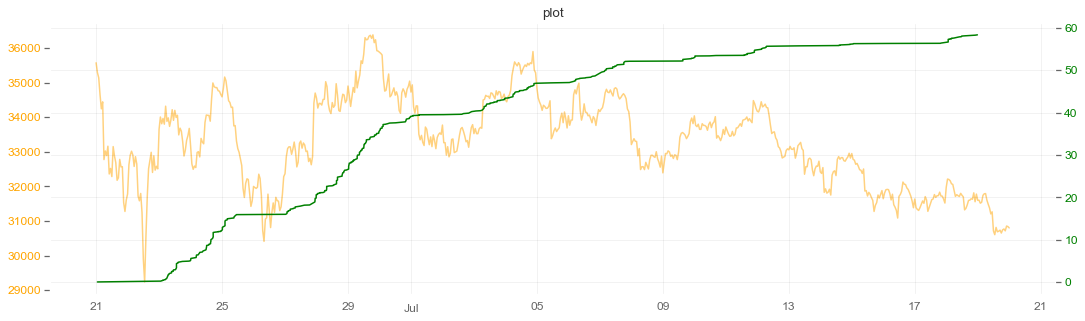

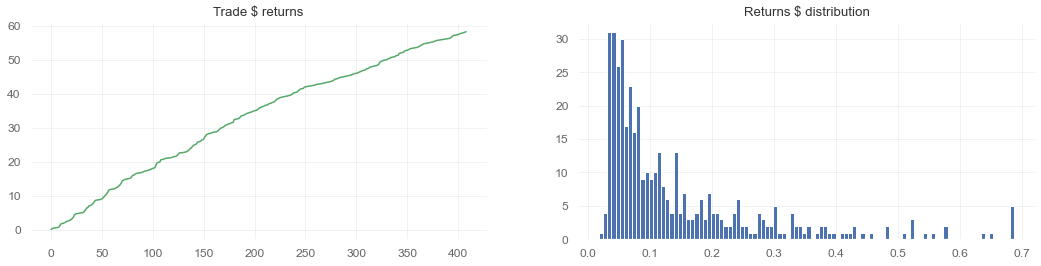

,Portfolio Summary
Trades,409
Min Balance,0.077874
Max Balance,58.343745
Final Balance,58.343745
Avg. Return (%),0.950048
Avg. Return ($),0.14265
Avg. Trade Duration (h),0 days 00:36:58.092909535


freqtrade.nbtools.remote_utils - Adding new row to table...
freqtrade.nbtools.remote_utils - Columns are not identical.
freqtrade.nbtools.remote_utils - New columns    : []
freqtrade.nbtools.remote_utils - Removed columns: ['pairlist', 'daily_profit']
freqtrade.nbtools.remote_utils - Inserting 'None' to removed columns


In [19]:
stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "opt", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)

# Unbiased Backtesting

freqtrade.nbtools.remote_utils - Load LightningContainer version 'latest' of project: '15n30-catboost_intentional' - asset_name: '15n30-catboost_intentional'.
freqtrade.nbtools.remote_utils - WARNING: You are using the LATEST version of LightningContainer asset!
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 5 pairs)
freqtrade.nbtools.preset.base_preset - Overwriting pairs (from 0 to 5 pairs)
freqtrade.nbtools.preset.base_preset - Setting config for 15n30-catboost_intentional ...
freqtrade.nbtools.preset.base_preset - Setting arg `datadir` to C:\CS\Python\crypto-collection\freqtrade\mount\data\binance
freqtrade.nbtools.preset.base_preset - Setting arg `timerange` to 20210721-20210820
freqtrade.nbtools.remote_utils - Load LightningContainer version 'latest' of project: '15n30-catboost_intentional' - asset_name: '15n30-catboost_intentional'.
freqtrade.nbtools.remote_utils - WARNING: You are using the LATEST version of LightningContainer asset!
freqtrade.nbtools.helpe

Populating Indicators:   0%|          | 0/4 [00:00<?, ?it/s]

freqtrade.nbtools.helper - "Backtest" executed in 0.50s
freqtrade.nbtools.backtest - Logging preset...
freqtrade.nbtools.backtest - [LOG PRESET OFFLINE SUCCESS]
freqtrade.nbtools.backtest - Sync preset with name: 15n30-catboost_intentional__backtest-2021-09-01_19-39-12
freqtrade.nbtools.backtest - with random name: satisfied-kazuya-virus
freqtrade.nbtools.backtest - [WANDB LOG PRESET CONTINUES IN BACKGROUND]
freqtrade.nbtools.helper - "Whole Backtesting Process (Backtest + Log)" executed in 27.18s


C:\CS\Python\crypto-collection\freqtrade\superft\freqtrade\nbtools\backtest.py:392: RuntimeWarning: divide by zero encountered in double_scalars
  "profit_per_drawdown": trades_summary["profit_total_abs"] / abs(trades_summary["max_drawdown_abs"]),
C:\CS\Python\crypto-collection\freqtrade\superft\freqtrade\nbtools\backtest.py:397: RuntimeWarning: divide by zero encountered in double_scalars
  "profit_factor": metadata["sum_profit_winners_abs"] / abs(metadata["sum_profit_losers_abs"]),


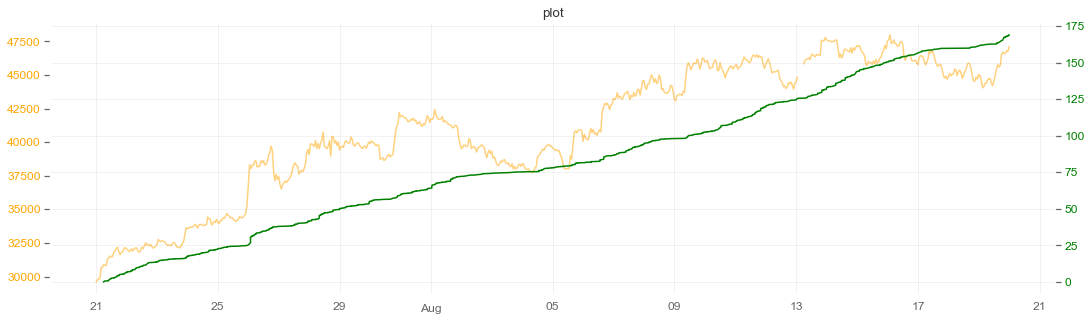

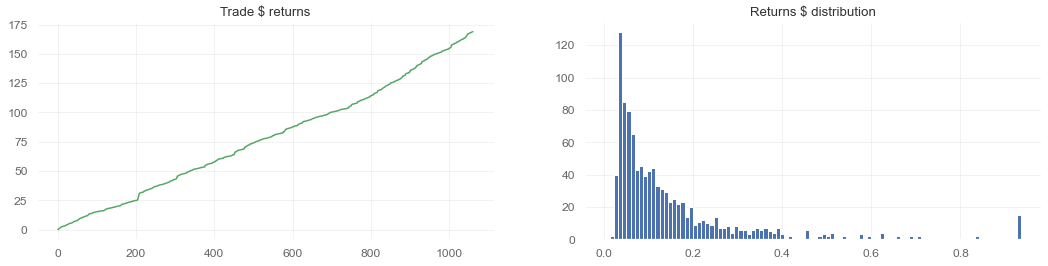

,Portfolio Summary
Trades,1061
Min Balance,0.096558
Max Balance,168.886909
Final Balance,168.886909
Avg. Return (%),1.060121
Avg. Return ($),0.159177
Avg. Trade Duration,0 days 00:38:23


freqtrade.nbtools.remote_utils - Adding new row to table...
freqtrade.nbtools.remote_utils - Columns are not identical.
freqtrade.nbtools.remote_utils - New columns    : []
freqtrade.nbtools.remote_utils - Removed columns: ['pairlist', 'daily_profit']
freqtrade.nbtools.remote_utils - Inserting 'None' to removed columns
freqtrade.nbtools.backtest - ===============================
freqtrade.nbtools.backtest - |  '15n30-catboost_intentional__backtest-2021-09-01_19-39-12'
freqtrade.nbtools.backtest - |  WANDB LOG PRESET FINISHED  
freqtrade.nbtools.backtest - ===============================


In [21]:
""" 
Just run once every "Sweet Spot" you got from Model x Strategy Optimize!
"""
stats, summary, preset = start_backtesting(opt_strategy, MODEL_NAME, "test", version=MODEL_VER)
trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plotting.plot_profits_timerange(trades, timerange=preset.timerange, path_mount=PATH_MOUNT)